## Problem Set 3

In [1]:
NUM_CASES = 2000

In [2]:
#Setup
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import numpy as np

df1 = pd.read_csv('data/cases_metadata.csv')[['caseid','case_reversed','judge_id','year','x_republican','log_cites']]

df1.dropna(subset=['x_republican'], inplace=True)
df1.dropna(subset=['log_cites'],inplace=True)
print(df1.isnull().sum())

from random import shuffle
keep = [True] * NUM_CASES + [False] * (len(df1) - NUM_CASES)
shuffle(keep)
df1 = df1[keep]
print('Number of rows: ',len(df1))
df1.head()

caseid           0
case_reversed    0
judge_id         0
year             0
x_republican     0
log_cites        0
dtype: int64
Number of rows:  2000


,caseid,case_reversed,judge_id,year,x_republican,log_cites
12,X28DP2,0,1951.0,1926.0,1.0,0.693147
14,X3C0H6,0,150.0,1926.0,0.0,1.386294
17,X3IK3N,0,1434.0,1925.0,1.0,1.945910
20,X9VBDP,0,741.0,1925.0,1.0,0.693147
27,X9VC00,0,2159.0,1925.0,0.0,0.693147


In [3]:
# load text documents
tmp=[]
for i in range(len(df1)):
    caseid=df1.iloc[i][0]
    caseid=caseid+'.txt'
    txt_file = [f for f in os.listdir('data/cases/') if f.endswith(caseid)]
    path='data/cases/'+txt_file[0]
    txt = open(path, 'r').read() # open a document
    tmp.append(txt)
df1['text']=tmp
df1.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites,text
12,X28DP2,0,1951.0,1926.0,1.0,0.693147,"SOPER , District Judge.\nThe plaintiff in err..."
14,X3C0H6,0,150.0,1926.0,0.0,1.386294,"BINGHAM , Circuit Judge.\nThe defendant Lee, ..."
17,X3IK3N,0,1434.0,1925.0,1.0,1.945910,"MILLER , District Judge.\nThis case is here o..."
20,X9VBDP,0,741.0,1925.0,1.0,0.693147,"GIBSON , District Judge.\nIn the court below ..."
27,X9VC00,0,2159.0,1925.0,0.0,0.693147,"WALKER , Circuit Judge.\nThe owner of the oil..."


In [4]:
# Capitalization
def capitalization(doc):
    return doc.lower()
df1['doc'] = df1['text'].apply(capitalization) # go to lower-case

#####
# Punctuation
#####

# recipe for fast punctuation removal
from string import punctuation

def remove_punctuation(doc):
    translator = str.maketrans('','',punctuation) 
    return doc.translate(translator)

df1['doc'] = df1['doc'].apply(remove_punctuation)

# Tokens
def tokenize(doc):
    return doc.split()
df1['doc'] = df1['doc'].apply(tokenize)

# remove numbers (keep if not a digit)
def remove_numbers(doc):
    return [t for t in doc if not t.isdigit()]
df1['doc'] = df1['doc'].apply(remove_numbers)
df1.head()

# Stopwords
from nltk.corpus import stopwords
stoplist = stopwords.words('english') 
def remove_stopwords(doc):
    return [t for t in doc if t not in stoplist]
df1['doc'] = df1['doc'].apply(remove_stopwords)

# Stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') # snowball stemmer, english
def stemming(doc):
    return [stemmer.stem(t) for t in doc]
df1['doc'] = df1['doc'].apply(stemming)

# Lemmatizing
#import nltk
#from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#wnl = WordNetLemmatizer()
#def lemmatizing(doc):
#    return [wnl.lemmatize(t) for t in doc]
#wnl.lemmatize('corporation'), wnl.lemmatize('corporations')
#df1['doc'] = df1['doc'].apply(lemmatizing)

# remove tokens
def remove_tokens(doc):
    return " ".join(doc)
df1['doc'] = df1['doc'].apply(remove_tokens)
df1.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites,text,doc
12,X28DP2,0,1951.0,1926.0,1.0,0.693147,"SOPER , District Judge.\nThe plaintiff in err...",soper district judg plaintiff error defend con...
14,X3C0H6,0,150.0,1926.0,0.0,1.386294,"BINGHAM , Circuit Judge.\nThe defendant Lee, ...",bingham circuit judg defend lee two other indi...
17,X3IK3N,0,1434.0,1925.0,1.0,1.945910,"MILLER , District Judge.\nThis case is here o...",miller district judg case appeal order lower c...
20,X9VBDP,0,741.0,1925.0,1.0,0.693147,"GIBSON , District Judge.\nIn the court below ...",gibson district judg court norfolk western rai...
27,X9VC00,0,2159.0,1925.0,0.0,0.693147,"WALKER , Circuit Judge.\nThe owner of the oil...",walker circuit judg owner oil tank barg boliko...


1) Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

In [5]:
###
# Word2Vec in gensim (short window)
###

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df1['doc']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v_short = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  20, # Minimum word count  
               window = 2, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v_short.init_sims(replace=True)

w2v_short.save('w2v-vectors-short_window.pkl')

#w2v.wv['judg'] # vector for "judge"

In [6]:
###
# Word2Vec in gensim (long window)
###

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df1['doc']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v_long = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  20, # Minimum word count  
               window = 16, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v_long.init_sims(replace=True)

w2v_long.save('w2v-vectors-long_window.pkl')

#w2v.wv['judg'] # vector for "judge"

In [7]:
w2v_short.wv.most_similar('judg') # most similar words

[('bench', 0.5354803800582886),
 ('nonjuri', 0.45362573862075806),
 ('court', 0.4510163962841034),
 ('ninth', 0.44431763887405396),
 ('bifurc', 0.43077629804611206),
 ('columbia', 0.41627806425094604),
 ('j', 0.3973234295845032),
 ('err', 0.39494645595550537),
 ('tribun', 0.39022624492645264),
 ('seventh', 0.37688666582107544)]

In [8]:
w2v_long.wv.most_similar('judg') # most similar words

[('bench', 0.5187643766403198),
 ('sit', 0.4388180673122406),
 ('seventh', 0.42127740383148193),
 ('duffi', 0.41558584570884705),
 ('tuttl', 0.414323627948761),
 ('voir', 0.38807764649391174),
 ('dire', 0.38681668043136597),
 ('kaufman', 0.381792277097702),
 ('columbia', 0.37480950355529785),
 ('court', 0.3621797263622284)]

In [9]:
from sklearn.manifold import TSNE
import re

vocab_long = list(dict(list(w2v_long.wv.vocab.items())[:100]))#select just 100 words #w2v_long.wv.vocab
X = w2v_long[vocab_long]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [10]:
df_long = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_long['word']=vocab_long
df_long.head()

,x,y,word
0,7.940682,-1.180282,circuit
1,9.605930,-0.069838,judg
2,-5.973284,-5.328211,henri
3,1.063312,-2.012688,mckinney
4,-0.217872,-3.511622,honor


In [11]:
vocab_short = list(dict(list(w2v_long.wv.vocab.items())[:100]))#select just 100 words #w2v_long.wv.vocab
X = w2v_short[vocab_short]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [12]:
df_short = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_short['word']=vocab_short
df_short.head()

,x,y,word
0,-1.140614,-6.011873,circuit
1,-2.204493,-5.515745,judg
2,2.203837,-4.653924,henri
3,2.900201,-4.431277,mckinney
4,-1.073400,7.083446,honor


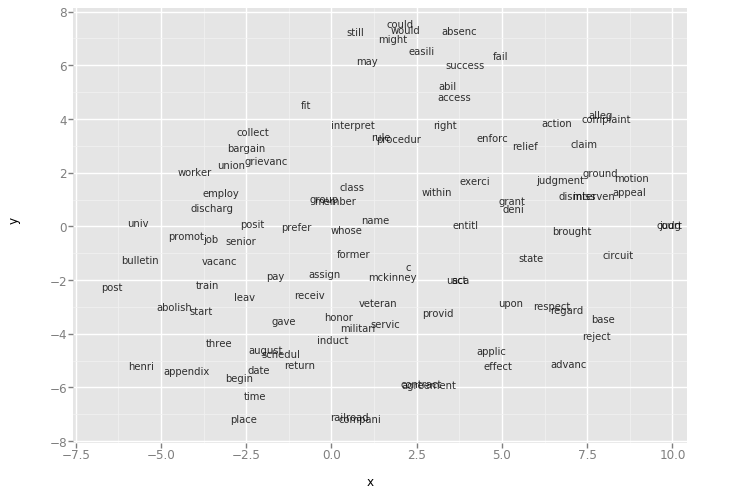

In [13]:
import ggplot as gg
chart = gg.ggplot( df_long, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
chart.show()

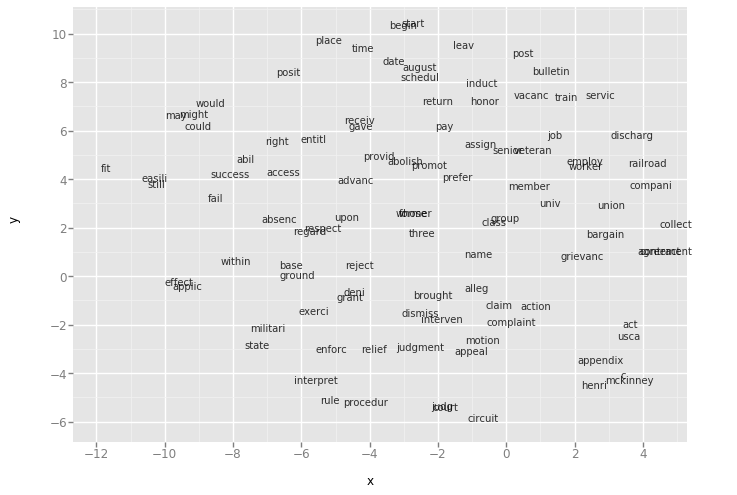

In [14]:
chart = gg.ggplot( df_short, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
chart.show()

In the model with smaller window vectors which are similar like 'base' and 'ground' are more closer to each other, because a window size of 2 considers only the neighbouring words in a sentence. With a bigger winow size, the words are analyzed in a larger context, which is why words like 'reject' and 'regard' are closer to 'base' in a model with windowsize = 16

2) Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice, and analyze differences by judge party.

In [15]:
df_rep=df1[df1['x_republican']==1]
print(len(df_rep))
df_rep.head()

1002


,caseid,case_reversed,judge_id,year,x_republican,log_cites,text,doc
12,X28DP2,0,1951.0,1926.0,1.0,0.693147,"SOPER , District Judge.\nThe plaintiff in err...",soper district judg plaintiff error defend con...
17,X3IK3N,0,1434.0,1925.0,1.0,1.945910,"MILLER , District Judge.\nThis case is here o...",miller district judg case appeal order lower c...
20,X9VBDP,0,741.0,1925.0,1.0,0.693147,"GIBSON , District Judge.\nIn the court below ...",gibson district judg court norfolk western rai...
30,X3CEDR,0,1024.0,1926.0,1.0,0.693147,"[**315] JAMES , District Judge.\nThis appeal,...",jame district judg appeal taken unit state pre...
32,X3T4NU,0,1345.0,1925.0,1.0,3.178054,"McCAMANT , Circuit Judge.\nOn the 30th of Mar...",mccamant circuit judg 30th march defend hawkin...


In [16]:
df_dem=df1[df1['x_republican']==0]
print(len(df_dem))
df_dem.head()

998


,caseid,case_reversed,judge_id,year,x_republican,log_cites,text,doc
14,X3C0H6,0,150.0,1926.0,0.0,1.386294,"BINGHAM , Circuit Judge.\nThe defendant Lee, ...",bingham circuit judg defend lee two other indi...
27,X9VC00,0,2159.0,1925.0,0.0,0.693147,"WALKER , Circuit Judge.\nThe owner of the oil...",walker circuit judg owner oil tank barg boliko...
29,X3CETE,0,37.0,1926.0,0.0,2.302585,"ANDERSON , Circuit Judge.\nOn an information ...",anderson circuit judg inform two countsth firs...
31,X3BD9F,0,1591.0,1926.0,0.0,1.098612,"PAGE , Circuit Judge.\nAppellant, incorporate...",page circuit judg appel incorpor law state ind...
40,X3C0HD,0,1591.0,1926.0,0.0,0.693147,"PAGE , Circuit Judge.\nN. & G. Taylor Company...",page circuit judg n g taylor compani copartner...


In [17]:
###
# Word2Vec in gensim for republican
###

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df_rep['doc']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v_rep = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  20, # Minimum word count  
               window = 6, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v_rep.init_sims(replace=True)

w2v_rep.save('w2v-vectors-republican.pkl')

#w2v.wv['judg'] # vector for "judge"

In [18]:
###
# Word2Vec in gensim for democrats
###

# word2vec requires sentences as input
from txt_utils import get_sentences
sentences = []
for doc in df_dem['doc']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v_dem = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  20, # Minimum word count  
               window = 6, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v_dem.init_sims(replace=True)

w2v_dem.save('w2v-vectors-democrats.pkl')

#w2v.wv['judg'] # vector for "judge"

In [19]:
w2v_rep.wv.most_similar('judg') # most similar words

[('bench', 0.5476809144020081),
 ('ninth', 0.49583011865615845),
 ('correct', 0.4900245666503906),
 ('tenth', 0.48619574308395386),
 ('court', 0.4727354645729065),
 ('voir', 0.4661923348903656),
 ('seventh', 0.4592641592025757),
 ('dire', 0.4340588450431824),
 ('bifurc', 0.43260976672172546),
 ('columbia', 0.41396307945251465)]

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [49]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('negro'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('negro'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','negro','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i])) 


adjectives most associated with the word  negro  

republican:          democrats: 

femal                anglo               
male                 black               
cleric               junior              
black                faculti             
keen                 columbus            
minor                white               
rif                  rapid               
faculti              ethnic              
older                lutheran            
junior               christian           
poor                 femal               
regular              courthous           
holi                 african             
christian            rough               
promot               male                


In [50]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('communist'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('communist'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','communist','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  communist  

republican:          democrats: 

affili               democrat            
overthrow            nazi                
democrat             affili              
newspap              ammco               
kondritz             frobo               
repr                 hitler              
fellow               german              
whose                frequent            
resign               lobbi               
close                soviet              
soviet               messag              
solicit              rival               
hong                 repr                
mexican              domin               
suspici              voic                


In [51]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('poor'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('poor'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','poor','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  poor  

republican:          democrats: 

regular              constant            
experienc            osten               
struggl              imag                
keen                 foster              
holi                 interact            
constant             parttim             
fewer                malfunct            
femal                visual              
male                 human               
matern               larger              
pregnant             pile                
experi               random              
inten                aquat               
cleric               subterfug           
readi                exploit             


In [52]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('christian'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('christian'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','christian','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  christian  

republican:          democrats: 

frederick            lutheran            
sectarian            prayergiv           
roman                faculti             
crech                negro               
footbal              white               
courthous            ethnic              
literari             sectarian           
civic                marsh               
messag               anglo               
keen                 holi                
academ               nonpubl             
faculti              messag              
secular              junior              
male                 footbal             
junior               osten               


In [53]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('indian'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('indian'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','indian','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  indian  

republican:          democrats: 

tribal               nonindian           
nonindian            osag                
compact              tribal              
migratori            confed              
pueblo               nativ               
foreign              pyramid             
sovereign            fsia                
graze                fisheri             
ratifi               sovereign           
pollut               shoshon             
riparian             powerex             
imperi               gregori             
canal                foreign             
fdic                 diminish            
solemn               ratifi              


In [54]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('american'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('american'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','american','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  american  

republican:          democrats: 

intl                 nativ               
domest               footbal             
bros                 lawrenc             
lloyd                cas                 
aerospac             intl                
nonprofit            mfg                 
canadian             nonprofit           
inc                  natl                
industri             daniel              
constr               theatr              
lincoln              bros                
chemic               constr              
theatr               southwest           
gen                  monro               
reinsur              sch                 


In [61]:
i=0
republican=[]

for tmp in w2v_rep.wv.most_similar(stemmer.stem('banker'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        republican.append(tmp[0])
        i=i+1

i=0
democrat=[]

for tmp in w2v_dem.wv.most_similar(stemmer.stem('banker'),topn=100)[:][:]:
    doc = nlp(tmp[0])
    if doc[0].pos_=='ADJ' and i < 15:
        democrat.append(tmp[0])
        i=i+1
        

print('adjectives most associated with the word','\033[1m','banker','\033[0m','\n')
print('republican:          democrats: \n')
for i in range(len(democrat)):
    print("%-20s %-20s" % (republican[i], democrat[i]))

adjectives most associated with the word  banker  

republican:          democrats: 

louisvil             manhattan           
kan                  reynold             
lincoln              louisvil            
cas                  vend                
lawrenc              midwest             
southwest            wet                 
columbus             red                 
nashvil              sidney              
lloyd                syndic              
vincent              theatr              
canadian             bondhold            
reynold              roy                 
bros                 lawrenc             
stuart               reinsur             
aerospac             plumb               
